In [2]:
# !pip install -q diffusers

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

g:\code\ai\stable-diffusion-webui_tobe\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([0, 1, 9, 2, 7, 3, 6, 0])


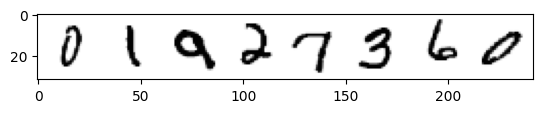

In [19]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download
    =True,transform=torchvision.transforms. ToTensor())
train_dataloader = DataLoader(dataset, batch_size=8,shuffle=True)
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

In [8]:
def corrupt(x, amount):
    """根据amount为输入x加入噪声，这就是退化过程"""
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1) # 整理形状以保证广播机制不出错
    return x*(1-amount) + noise*amount

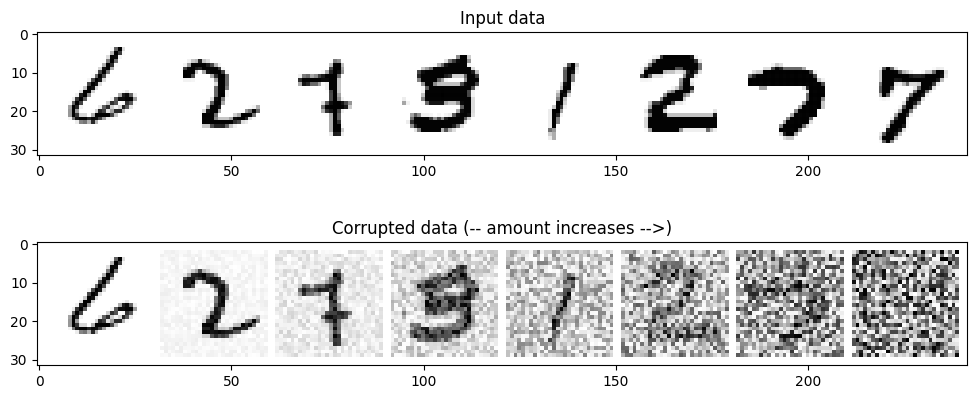

In [5]:
# 绘制输入数据
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# 加入噪声
amount = torch.linspace(0, 1, x.shape[0]) # 从0到1 → 退化更强烈了
noised_x = corrupt(x, amount)

# 绘制加噪版本的图像
axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys');

In [6]:
class BasicUNet(nn.Module):
    """一个十分简单的UNet网络部署"""
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
        ])
        self.act = nn.SiLU()            # 激活函数
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))     # 通过运算层与激活函数
            if i < 2:              # 选择除了第3层（最后一层）以外的层
                h.append(x)          # 排列供残差连接使用的数据
                x = self.downscale(x)# 进行下采样以适配下一层的输入
        for i, l in enumerate(self.up_layers):
            if i > 0:              # 选择除了第1个上采样层以外的层
                x = self.upscale(x)# Upscale上采样
                x += h.pop()       # 得到之前排列好的供残差连接使用的数据
            x = self.act(l(x))     # 通过运算层与激活函数
        return x

In [7]:
net = BasicUNet()
x = torch.rand(8, 1, 28, 28)
net(x).shape

torch.Size([8, 1, 28, 28])

In [8]:
sum([p.numel() for p in net.parameters()])

309057

Finished epoch 0. Average loss for this epoch: 0.025806
Finished epoch 1. Average loss for this epoch: 0.019767
Finished epoch 2. Average loss for this epoch: 0.018319


(0.0, 0.1)

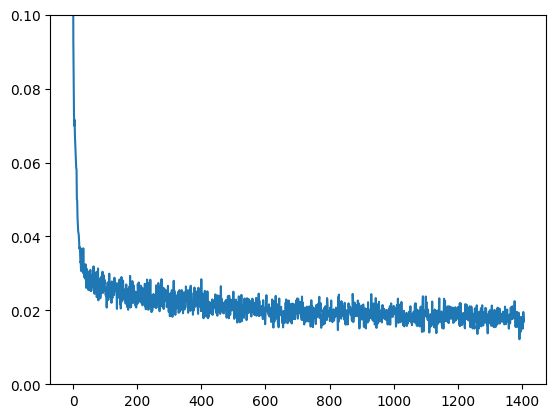

In [9]:
# 数据加载器（你可以调整batch_size）
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size,
    shuffle=True)

# 设置我们将在整个数据集上运行多少个周期
n_epochs = 3

# 创建网络
net = BasicUNet()
net.to(device)

# 指定损失函数
loss_fn = nn.MSELoss()

# 指定优化器
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# 记录训练过程中的损失，供后期查看
losses = []

# 训练
for epoch in range(n_epochs):
    for x, y in train_dataloader:
        # 得到数据并准备退化
        x = x.to(device)                      # 将数据加载到GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # 随机选取
                                                         # 噪声量
        noisy_x = corrupt(x, noise_amount) # 创建“带噪”的输入noisy_x

        # 得到模型的预测结果
        pred = net(noisy_x)

        # 计算损失函数
        loss = loss_fn(pred, x) # 输出与真实“干净”的x有多接近？

        # 反向传播并更新参数
        opt.zero_grad()
        loss.backward()
        opt.step()
        # 存储损失，供后期查看
        losses.append(loss.item())

    # 输出在每个周期训练得到的损失的均值
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# 查看损失曲线
plt.plot(losses)
plt.ylim(0, 0.1)

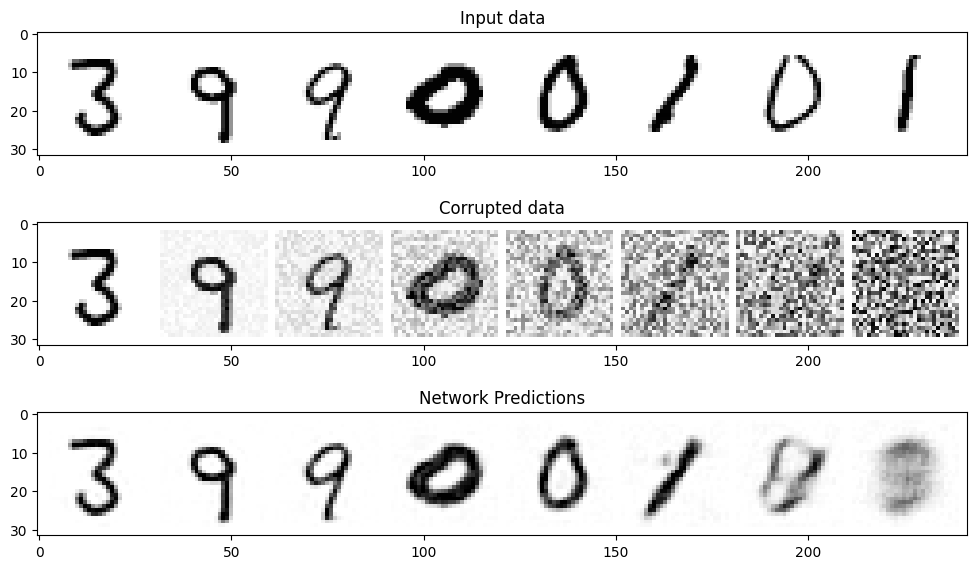

In [10]:
# 可视化模型在“带噪”输入上的表现
# 得到一些数据
x, y = next(iter(train_dataloader))
x = x[:8]  # 为了便于展示，只选取前8条数据

# 在（0，1）区间选择退化量
amount = torch.linspace(0, 1, x.shape[0])   # 从0到1→退化更强烈了
noised_x = corrupt(x, amount)

# 得到模型的预测结果
with torch.no_grad():
    preds = net(noised_x.to(device)).detach().cpu()

# 绘图
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1),
    cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1),
    cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1),
    cmap='Greys');

# 采样过程

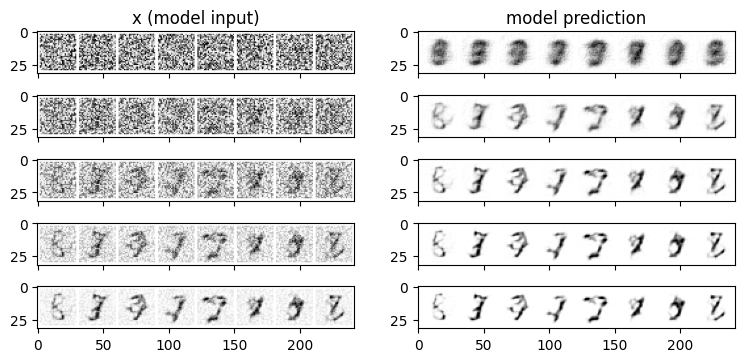

In [12]:
# 采样策略：把采样过程拆解为5步，每次只前进一步
n_steps = 5
x = torch.rand(8, 1, 28, 28).to(device) # 从完全随机的值开始
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad():               # 在推理时不需要考虑张量的导数
        pred = net(x)                   # 预测“去噪”后的图像
    pred_output_history.append(pred.detach().cpu())
                               # 将模型的输出保存下来，以便后续绘图时使用
    mix_factor = 1/(n_steps - i)            # 设置朝着预测方向移动多少
    x = x*(1-mix_factor) + pred*mix_factor  # 移动过程
    step_history.append(x.detach().cpu())   # 记录每一次移动，以便后续
                                            # 绘图时使用

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])
       [0].clip(0, 1), cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')

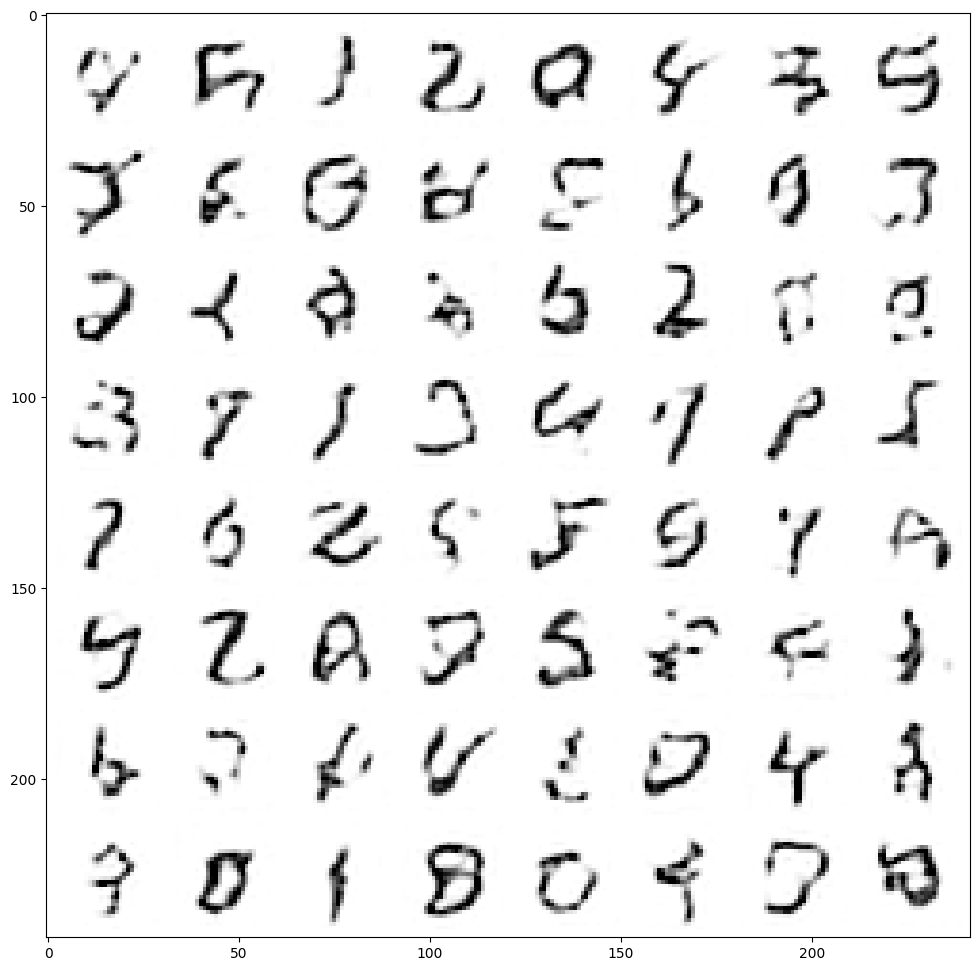

In [16]:
# 将采样过程拆解成40步
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (1-(i/n_steps))# 将噪声量从高到低移动
    with torch.no_grad():
        pred = net(x)
    mix_factor = 1/(n_steps - i)
    x = x*(1-mix_factor) + pred*mix_factor
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)
   [0].clip(0, 1), cmap='Greys')

# 使用 diffusers 里的模型

In [3]:
model = UNet2DModel(
    sample_size=28,           # the target image resolution
    in_channels=1,            # the number of input channels, 3 for RGB images
    out_channels=1,           # the number of output channels
    layers_per_block=2,       # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64), # Roughly matching our basic unet example
    down_block_types=( 
        "DownBlock2D",        # a regular ResNet downsampling block
        "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ), 
    up_block_types=(
        "AttnUpBlock2D", 
        "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",          # a regular ResNet upsampling block
      ),
)
print(model)

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): LoRACompatibleConv(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): LoRACompatibleLinear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): LoRACompatibleConv(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleLis

In [4]:
sum([p.numel() for p in model.parameters()])

1707009

Finished epoch 0. Average loss for this epoch: 0.019409
Finished epoch 1. Average loss for this epoch: 0.012947
Finished epoch 2. Average loss for this epoch: 0.011788


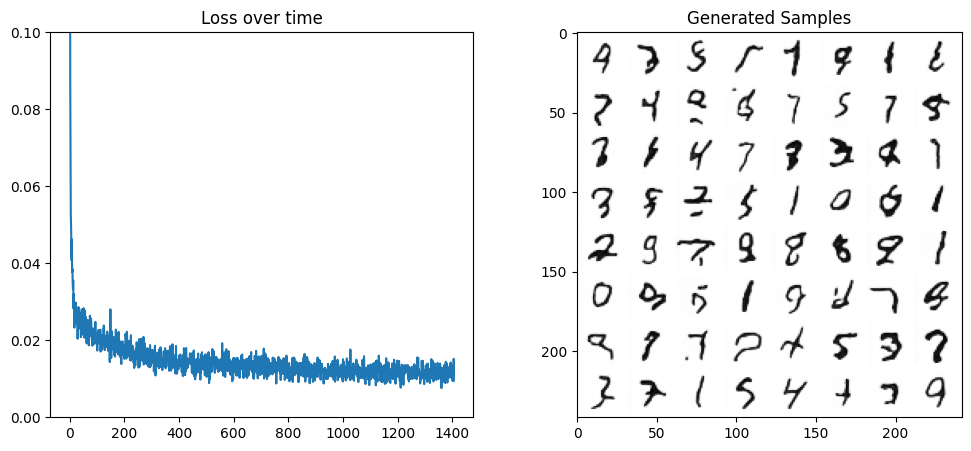

In [9]:
#@markdown Trying UNet2DModel instead of BasicUNet:

# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 3

# Create the network
net = UNet2DModel(
    sample_size=28,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ), 
    up_block_types=(
        "AttnUpBlock2D", 
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",   # a regular ResNet upsampling block
      ),
) #<<<
net.to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3) 

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x, 0).sample #<<< Using timestep 0 always, adding .sample

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# Plot losses and some samples
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title('Loss over time')

# Samples
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x, 0).sample
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor

axs[1].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Generated Samples');

# 退化过程

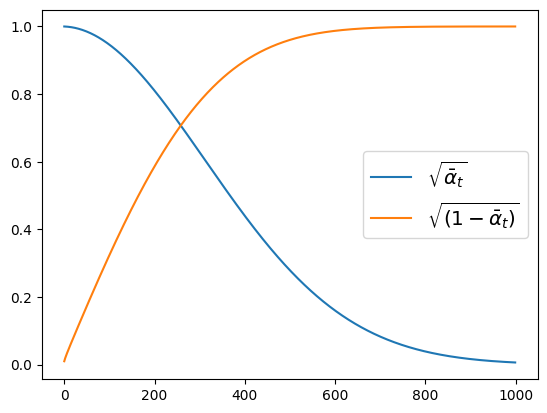

In [10]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

X shape torch.Size([8, 1, 28, 28])
Noisy X shape torch.Size([8, 1, 28, 28])


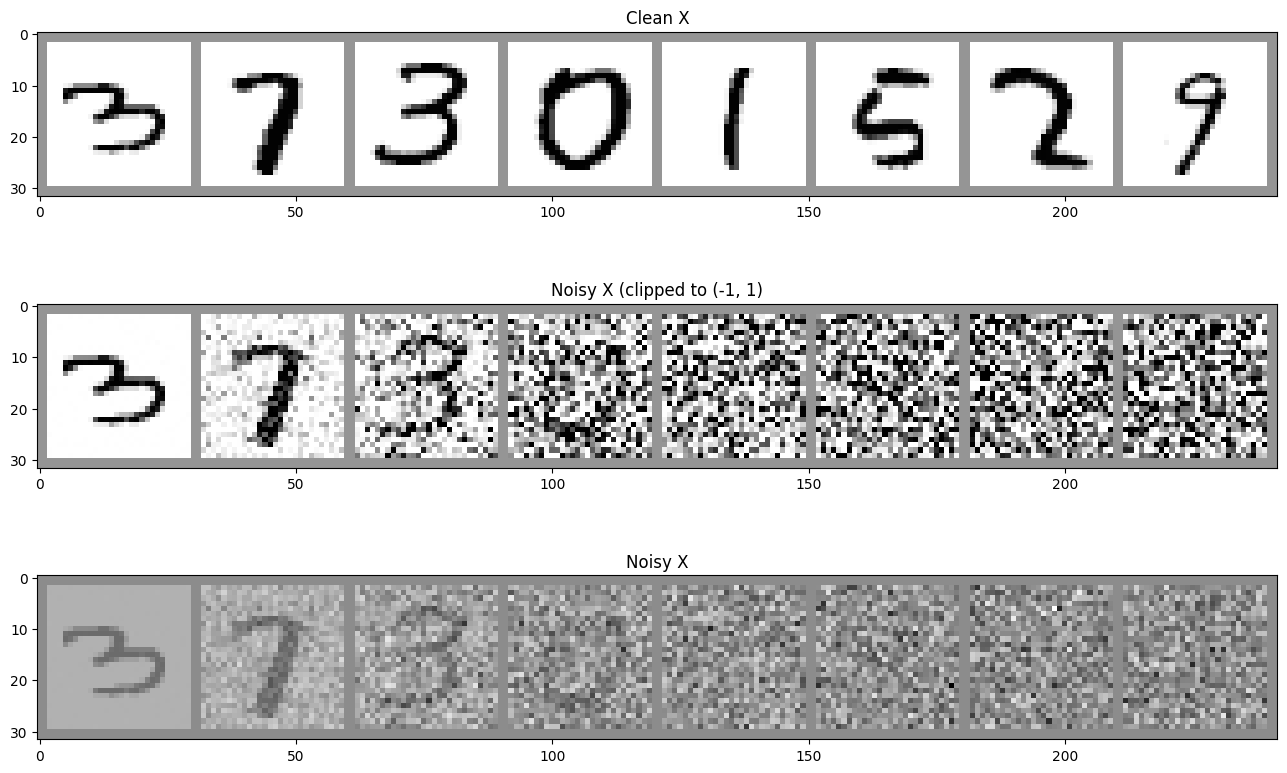

In [12]:
#@markdown visualize the DDPM noising process for different timesteps:

# Noise a batch of images to view the effect
fig, axs = plt.subplots(3, 1, figsize=(16, 10))
xb, yb = next(iter(train_dataloader))
xb = xb.to(device)[:8]
xb = xb * 2. - 1. # Map to (-1, 1)
print('X shape', xb.shape)

# Show clean inputs
axs[0].imshow(torchvision.utils.make_grid(xb[:8])[0].detach().cpu(), cmap='Greys')
axs[0].set_title('Clean X')

# Add noise with scheduler
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb) # << NB: randn not rand
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print('Noisy X shape', noisy_xb.shape)

# Show noisy version (with and without clipping)
axs[1].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu().clip(-1, 1),  cmap='Greys')
axs[1].set_title('Noisy X (clipped to (-1, 1)')
axs[2].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu(),  cmap='Greys')
axs[2].set_title('Noisy X');

In [24]:
# 让模型去预测噪声, 而不是像之前那样预测干净的图像
xb, yb = next(iter(train_dataloader))
timesteps = torch.linspace(0, 999, 8).long()

noise = torch.randn_like(xb) # << 注意是使用randn而不是rand, 就是使用正态分布而不是均匀分布
noisy_x = noise_scheduler.add_noise(xb, noise, timesteps)
model_prediction = model(noisy_x, timesteps).sample

print("noise shape:", noise.shape)
print("noisy_x shape:", noisy_x.shape)
print("model_prediction shape:", model_prediction.shape)

mse_loss = nn.MSELoss()
loss = mse_loss(model_prediction, noise) # 预测结果与噪声

noise shape: torch.Size([8, 1, 28, 28])
noisy_x shape: torch.Size([8, 1, 28, 28])
model_prediction shape: torch.Size([8, 1, 28, 28])


In [26]:
timesteps

tensor([  0, 142, 285, 428, 570, 713, 856, 999])